# Auth


In [ ]:
from google.colab import auth
auth.authenticate_user()

# Init Client

In [ ]:
from google.cloud import bigquery

project_id = "icoads-time-series-analysis"
client = bigquery.Client(project=project_id)

# Import Python Libs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from itertools import combinations
from statsmodels.tsa.seasonal import STL

# Inspect Schema

In [ ]:
table = client.get_table("icoads-time-series-analysis.icoads_data.icoads_raw_aggregated")
[(f.name, f.field_type, f.mode) for f in table.schema]

[('year', 'INTEGER', 'NULLABLE'),
 ('month', 'INTEGER', 'NULLABLE'),
 ('day', 'INTEGER', 'NULLABLE'),
 ('hour', 'FLOAT', 'NULLABLE'),
 ('latitude', 'FLOAT', 'NULLABLE'),
 ('longitude', 'FLOAT', 'NULLABLE'),
 ('imma_version', 'INTEGER', 'NULLABLE'),
 ('attm_count', 'INTEGER', 'NULLABLE'),
 ('time_indicator', 'INTEGER', 'NULLABLE'),
 ('latlong_indicator', 'INTEGER', 'NULLABLE'),
 ('ship_course', 'INTEGER', 'NULLABLE'),
 ('ship_speed', 'INTEGER', 'NULLABLE'),
 ('national_source_indicator', 'INTEGER', 'NULLABLE'),
 ('id_indicator', 'INTEGER', 'NULLABLE'),
 ('callsign', 'STRING', 'NULLABLE'),
 ('country_code', 'STRING', 'NULLABLE'),
 ('wind_direction_indicator', 'INTEGER', 'NULLABLE'),
 ('wind_direction_true', 'INTEGER', 'NULLABLE'),
 ('wind_speed_indicator', 'INTEGER', 'NULLABLE'),
 ('wind_speed', 'FLOAT', 'NULLABLE'),
 ('visibility_indicator', 'INTEGER', 'NULLABLE'),
 ('visibility', 'INTEGER', 'NULLABLE'),
 ('present_weather', 'INTEGER', 'NULLABLE'),
 ('past_weather', 'INTEGER', 'NULLABLE

# Partition by Year

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `icoads-time-series-analysis.icoads_data.icoads_ptn`
PARTITION BY RANGE_BUCKET(year, GENERATE_ARRAY(2001, 2018, 1))
CLUSTER BY source_id, deck, lat_ftoi, long_ftoi AS
SELECT *,
    CAST(FLOOR(latitude) AS INT64) lat_ftoi,
    CAST(FLOOR(longitude) AS INT64) long_ftoi
FROM `icoads-time-series-analysis.icoads_data.icoads_raw_aggregated`;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

# Prelim Clean Fields

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE VIEW `icoads-time-series-analysis.icoads_data.icoads_wv` AS
SELECT *,
    NULLIF(air_temperature, 99.9) AS air_temp_c,
    NULLIF(sea_surface_temp, 99.9) AS sst_c,
    NULLIF(wind_speed, 99.9) AS wind_spd_ms,
    NULLIF(sea_level_pressure, 9999) AS slp_hpa,
    TIMESTAMP_TRUNC(timestamp, HOUR) AS t_hour,
    DATE_TRUNC(DATE(timestamp), MONTH) AS d_month,
    EXTRACT(YEAR FROM timestamp) AS yy,
    EXTRACT(MONTH from timestamp) AS mm,
    CAST(FLOOR(latitude) AS INT64) AS lat1,
    CAST(FLOOR(longitude) AS INT64) AS long1,
    CAST(FLOOR(latitude*2)/2 AS FLOAT64) AS lat05,
    CAST(FLOOR(longitude*2)/2 AS FLOAT64) AS long05,
    CONCAT(COALESCE(CAST(deck AS STRING),''),'-',
         COALESCE(CAST(source_id AS STRING),''),'-',
         COALESCE(callsign,'')) AS platform_key
FROM `icoads-time-series-analysis.icoads_data.icoads_ptn`;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH hp AS (
    SELECT t_hour,
        CAST(ROUND(latitude, 1) AS FLOAT64) lat01,
        CAST(ROUND(longitude, 1) AS FLOAT64) long01,
        platform_key, COUNT(*) n
    FROM `icoads-time-series-analysis.icoads_data.icoads_wv`
    WHERE yy BETWEEN 2005 AND 2017
    GROUP BY 1,2,3,4
)
SELECT * FROM hp WHERE n>1 ORDER BY n DESC LIMIT 100;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=100, table_html='<table border="1" class="dataframe table table-striped ta…

Computation deferred. Computation will process 6.3 kB

# Visualizations

### Missing Data

In [ ]:
%%bigquery missing_df --project icoads-time-series-analysis
SELECT
    d_month,
    AVG(CAST(air_temp_c IS NULL AS INT64)) air_missing,
    AVG(CAST(sst_c IS NULL AS INT64)) sst_missing,
    AVG(CAST(wind_spd_ms IS NULL AS INT64)) wind_missing,
    AVG(CAST(slp_hpa IS NULL AS INT64)) slp_missing
FROM `icoads-time-series-analysis.icoads_data.icoads_wv`
WHERE yy BETWEEN 2005 AND 2017
GROUP BY d_month ORDER BY d_month;

Query is running:   0%|          |

Downloading:   0%|          |

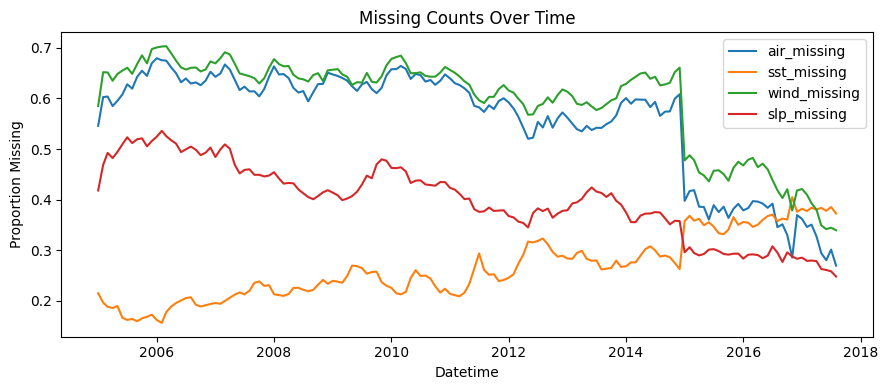

In [ ]:
import matplotlib.pyplot as plt
missing_df.plot(
    x = "d_month", y = ["air_missing", "sst_missing", "wind_missing", "slp_missing"],
    figsize=(9, 4),
    title = "Missing Counts Over Time"
)
plt.ylabel("Proportion Missing")
plt.xlabel("Datetime")
plt.tight_layout();

### Distributions for SST

In [ ]:
%%bigquery sst_hist
WITH bins AS (
    SELECT CAST(FLOOR(sst_c) AS INT64) AS bin
    FROM `icoads-time-series-analysis.icoads_data.icoads_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND sst_c IS NOT NULL
)
SELECT bin, COUNT(*) AS n FROM bins GROUP BY bin ORDER BY bin;

Query is running:   0%|          |

Downloading:   0%|          |

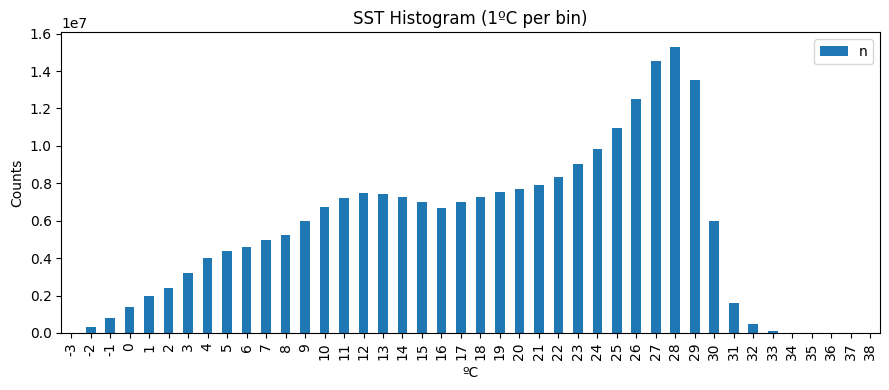

In [ ]:
sst_hist.plot(
    x = "bin", y = "n",
    kind = "bar",
    figsize = (9, 4),
    title = "SST Histogram (1ºC per bin)"
)
plt.ylabel("Counts")
plt.xlabel("ºC")
plt.tight_layout();

In [ ]:
%%bigquery qtl_df
with qtl AS (
    SELECT d_month, APPROX_QUANTILES(sst_c, 100) AS q
    FROM `icoads-time-series-analysis.icoads_data.icoads_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND sst_c IS NOT NULL
    GROUP BY d_month
)
SELECT d_month,
    q[OFFSET(25)] AS q1,
    q[OFFSET(50)] AS q2,
    q[OFFSET(75)] AS q3
FROM qtl
ORDER BY d_month;

Query is running:   0%|          |

Downloading:   0%|          |

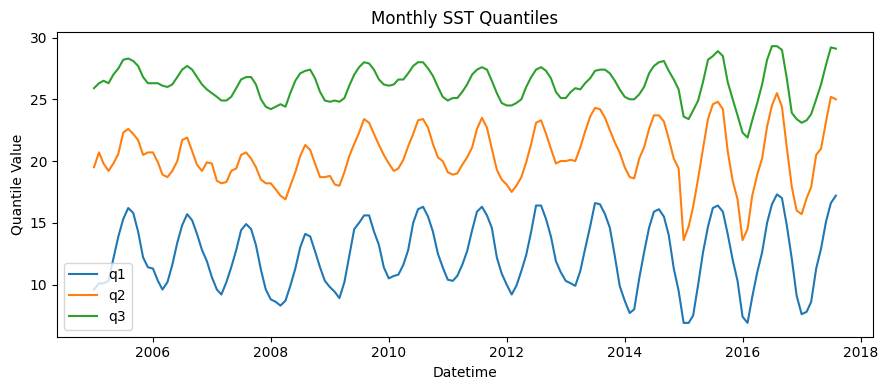

In [ ]:
qtl_df.plot(
    x = "d_month", y = ["q1", "q2", "q3"],
    figsize = (9, 4),
    title = "Monthly SST Quantiles"
)
plt.ylabel("Quantile Value")
plt.xlabel("Datetime")
plt.tight_layout();

In [ ]:
%%bigquery grid_df
WITH grid AS (
    SELECT CAST(FLOOR(latitude) AS INT64) AS lat1,
        CAST(FLOOR(longitude) AS INT64) AS long1,
        AVG(sst_c) AS mean_sst, COUNT(*) AS n
    FROM `icoads-time-series-analysis.icoads_data.icoads_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND sst_c IS NOT NULL
    GROUP BY lat1, long1
)
SELECT * FROM grid;

Query is running:   0%|          |

Downloading:   0%|          |

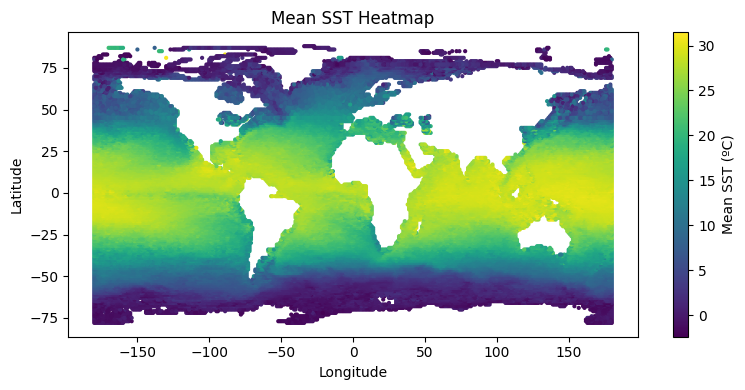

In [ ]:
ax = grid_df.plot.scatter(
    x = "long1", y = "lat1", s = 4,
    c = "mean_sst", figsize = (8, 4),
    title = "Mean SST Heatmap",
    colorbar = False
)
m = ax.collections[0]
cbar = plt.colorbar(m, ax = ax)
cbar.set_label("Mean SST (ºC)")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.tight_layout()

# Uni/Bi-variate Analysis

### Univariate

In [ ]:
%%bigquery --project icoads-time-series-analysis
DECLARE cols ARRAY<STRING> DEFAULT ['sst_c','air_temp_c','wind_spd_ms','slp_hpa'];
DECLARE start_y INT64 DEFAULT 2005;
DECLARE end_y INT64 DEFAULT 2017;
DECLARE col STRING;

CREATE OR REPLACE TABLE `icoads-time-series-analysis.icoads_data.univ_summary` (
    feature STRING,
    n INT64,
    n_nonnull INT64,
    miss_rate FLOAT64,
    mean FLOAT64,
    stdev FLOAT64,
    min FLOAT64,
    q1 FLOAT64,
    q2 FLOAT64,
    q3 FLOAT64,
    max FLOAT64
);
TRUNCATE TABLE `icoads-time-series-analysis.icoads_data.univ_summary`;

FOR rec IN (SELECT c AS feature FROM UNNEST(cols) AS c) DO
    SET col = rec.feature;
    EXECUTE IMMEDIATE FORMAT("""
        INSERT INTO `icoads-time-series-analysis.icoads_data.univ_summary`
        WITH q AS (
            SELECT APPROX_QUANTILES(%s, 100) AS qt
            FROM `icoads-time-series-analysis.icoads_data.icoads_wv`
            WHERE yy BETWEEN %d AND %d AND %s IS NOT NULL
        )
        SELECT '%s' AS feature,
        COUNT(*) AS n,
        COUNT(%s) AS n_nonnull,
        SAFE_DIVIDE(COUNTIF(%s IS NULL), COUNT(*)) AS miss_rate,
        AVG(%s) AS mean,
        STDDEV(%s) AS stdev,
        MIN(%s) AS min,
        (SELECT qt[OFFSET(25)] FROM q) AS q1,
        (SELECT qt[OFFSET(50)] FROM q) AS q2,
        (SELECT qt[OFFSET(75)] FROM q) AS q3,
        MAX(%s) AS max
        FROM `icoads-time-series-analysis.icoads_data.icoads_wv`
        WHERE yy BETWEEN %d AND %d
        """, col, start_y, end_y, col, col, col, col, col, col, col, col, start_y, end_y
    );
END FOR;

SELECT * FROM `icoads-time-series-analysis.icoads_data.univ_summary` ORDER BY feature;

Query is running:   0%|          |

Downloading:   0%|          |

,feature,n,n_nonnull,miss_rate,mean,stdev,min,q1,q2,q3,max
0,air_temp_c,321322074,156349971,0.513417,15.908639,9.812280,-49.0,9.1,16.2,24.7,43.6
1,slp_hpa,321322074,201827202,0.371885,1014.545952,9.377233,920.0,1010.6,1015.5,1020.0,1060.0
2,sst_c,321322074,228505759,0.288858,19.068537,8.274225,-2.8,12.5,20.4,26.5,38.7
3,wind_spd_ms,321322074,142109316,0.557736,5.255364,3.396502,0.1,2.6,4.6,7.0,52.5


## Bivariate

### Correlations for All Pairs

In [ ]:
%%bigquery --project icoads-time-series-analysis
DECLARE cols ARRAY<STRING> DEFAULT ['sst_c','air_temp_c','wind_spd_ms','slp_hpa'];
DECLARE start_y INT64 DEFAULT 2005;
DECLARE end_y INT64 DEFAULT 2017;

CREATE OR REPLACE TABLE `icoads-time-series-analysis.icoads_data.biv_corr_global` (x STRING, y STRING, r FLOAT64);
TRUNCATE TABLE `icoads-time-series-analysis.icoads_data.biv_corr_global`;
CREATE OR REPLACE TABLE `icoads-time-series-analysis.icoads_data.biv_corr_monthly` (x STRING, y STRING, mm INT64, r FLOAT64);
TRUNCATE TABLE `icoads-time-series-analysis.icoads_data.biv_corr_monthly`;
CREATE TEMP TABLE pairs AS
SELECT c1 AS x, c2 AS y
FROM UNNEST(cols) c1 WITH OFFSET i
JOIN UNNEST(cols) c2 WITH OFFSET j ON i < j;

-- global corr
INSERT INTO `icoads-time-series-analysis.icoads_data.biv_corr_global`
SELECT x, y, CORR(xv, yv) AS r
FROM (SELECT
    CASE x WHEN 'sst_c' THEN sst_c
           WHEN 'air_temp_c' THEN air_temp_c
           WHEN 'wind_spd_ms' THEN wind_spd_ms
           ELSE slp_hpa END AS xv,
    CASE y WHEN 'sst_c' THEN sst_c
           WHEN 'air_temp_c' THEN air_temp_c
           WHEN 'wind_spd_ms' THEN wind_spd_ms
           ELSE slp_hpa END AS yv,
    x, y FROM `icoads-time-series-analysis.icoads_data.icoads_wv`
    CROSS JOIN pairs
    WHERE yy BETWEEN start_y AND end_y
) s GROUP BY x, y;

-- monthly corr
INSERT INTO `icoads-time-series-analysis.icoads_data.biv_corr_monthly`
SELECT x, y, mm, CORR(xv, yv) AS r
FROM (SELECT mm,
    CASE x WHEN 'sst_c' THEN sst_c
           WHEN 'air_temp_c' THEN air_temp_c
           WHEN 'wind_spd_ms' THEN wind_spd_ms
           ELSE slp_hpa END AS xv,
    CASE y WHEN 'sst_c' THEN sst_c
           WHEN 'air_temp_c' THEN air_temp_c
           WHEN 'wind_spd_ms' THEN wind_spd_ms
           ELSE slp_hpa END AS yv,
    x, y FROM `icoads-time-series-analysis.icoads_data.icoads_wv`
    CROSS JOIN pairs
    WHERE yy BETWEEN start_y AND end_y
) s GROUP BY x, y, mm
ORDER BY x, y, mm;

Query is running:   0%|          |

""


In [ ]:
%%bigquery corr_g --project icoads-time-series-analysis
SELECT * FROM `icoads-time-series-analysis.icoads_data.biv_corr_global`
ORDER BY ABS(r) DESC;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery corr_m --project icoads-time-series-analysis
SELECT * FROM `icoads-time-series-analysis.icoads_data.biv_corr_monthly`
ORDER BY x, y, mm;

Query is running:   0%|          |

Downloading:   0%|          |

## Pairwise Correlations

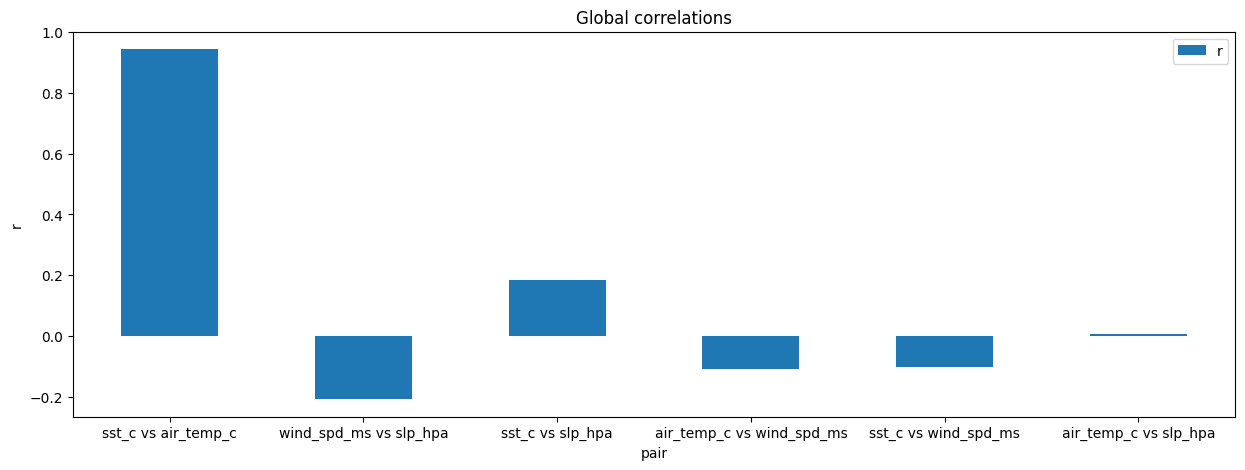

In [ ]:
corr_g["pair"] = corr_g["x"] + " vs " + corr_g["y"]
ax = corr_g.plot(
    x = "pair", y = "r", kind = "bar",
    figsize = (15, 5), rot = 0,
    title = "Global correlations"
)
ax.set_ylabel("r");


Text(0.5, 1.0, 'Correlation Matrix')

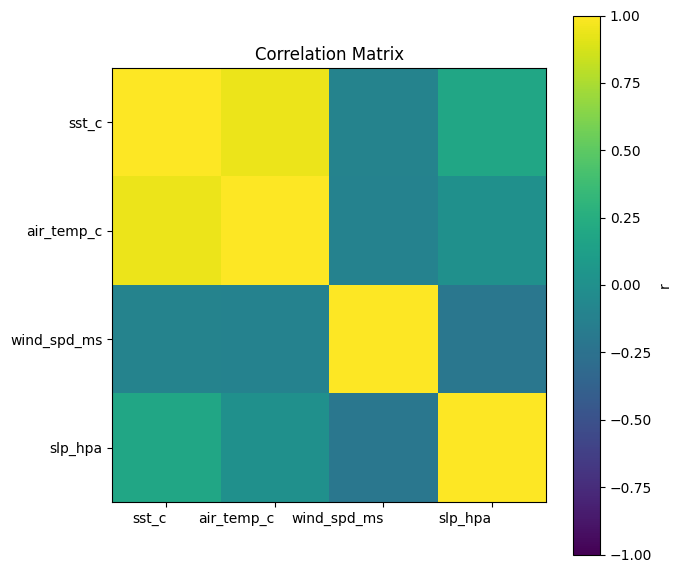

In [ ]:
features = ['sst_c', 'air_temp_c', 'wind_spd_ms', 'slp_hpa']
mat = pd.DataFrame(
    np.eye(len(features)),
    index = features,
    columns = features
)

for _, row in corr_g.iterrows():
    mat.loc[row["x"], row["y"]] = row["r"]
    mat.loc[row["y"], row["x"]] = row["r"]

plt.figure(figsize = (7, 7))
im = plt.imshow(mat.values, vmin = -1, vmax = 1)
plt.xticks(range(len(features)), features, rotation = 0, ha = "right")
plt.yticks(range(len(features)), features)
cbar = plt.colorbar(im)
cbar.set_label("r")
plt.title("Correlation Matrix")


## Monthly Correlations

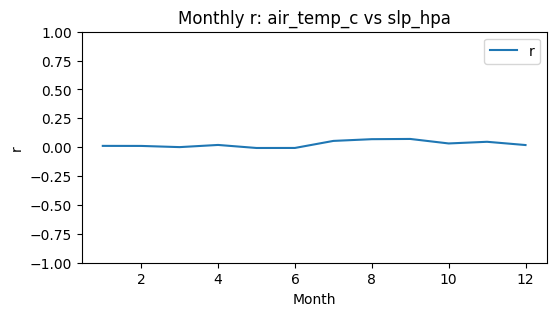

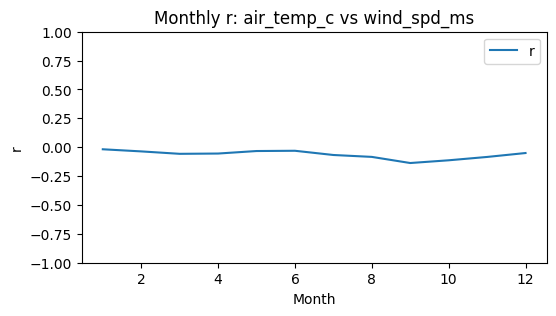

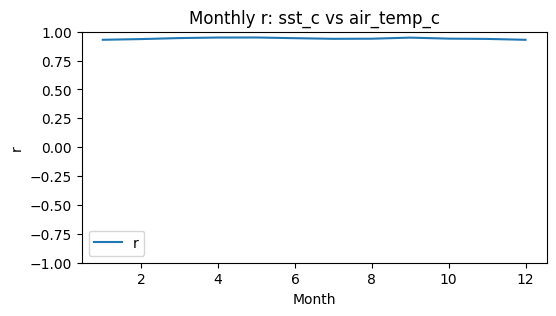

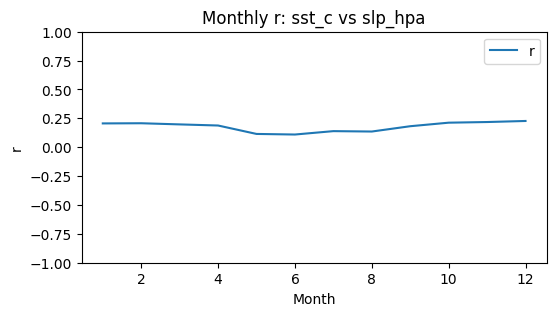

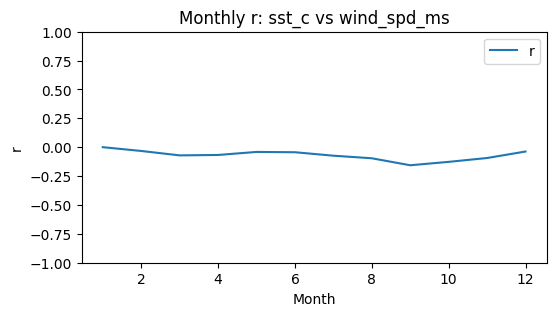

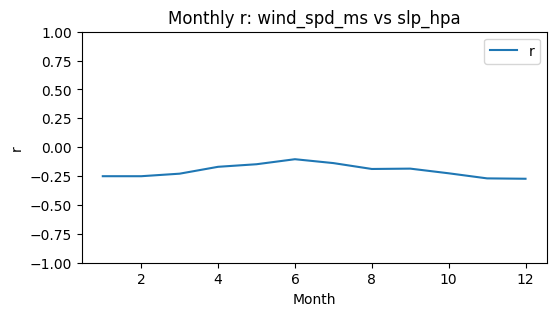

In [ ]:
pairs = corr_m[["x", "y"]].drop_duplicates()

for _, p in pairs.iterrows():
    sub = corr_m[(corr_m.x == p.x) & (corr_m.y == p.y)]
    ax = sub.plot(
        x = "mm", y = "r",
        figsize = (6, 3),
        title = f"Monthly r: {p.x} vs {p.y}"
    )
    ax.set_ylim(-1, 1)
    ax.set_xlabel("Month")
    ax.set_ylabel("r")


# Distributions

In [ ]:
%%bigquery dist_bins --project icoads-time-series-analysis
WITH vars AS (
    SELECT 'sst_c' AS feature, sst_c AS v
    FROM `icoads-time-series-analysis.icoads_data.icoads_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND sst_c IS NOT NULL
    UNION ALL
    SELECT 'air_temp_c', air_temp_c
    FROM `icoads-time-series-analysis.icoads_data.icoads_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND air_temp_c IS NOT NULL
    UNION ALL
    SELECT 'wind_spd_ms', wind_spd_ms
    FROM `icoads-time-series-analysis.icoads_data.icoads_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND wind_spd_ms IS NOT NULL
    UNION ALL
    SELECT 'slp_hpa', slp_hpa
    FROM `icoads-time-series-analysis.icoads_data.icoads_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND slp_hpa IS NOT NULL
)
SELECT
    feature,
    CAST(FLOOR(v) AS INT64) AS bin,
    COUNT(*) AS n
FROM vars
GROUP BY feature, bin
ORDER BY feature, bin;

Query is running:   0%|          |

Downloading:   0%|          |

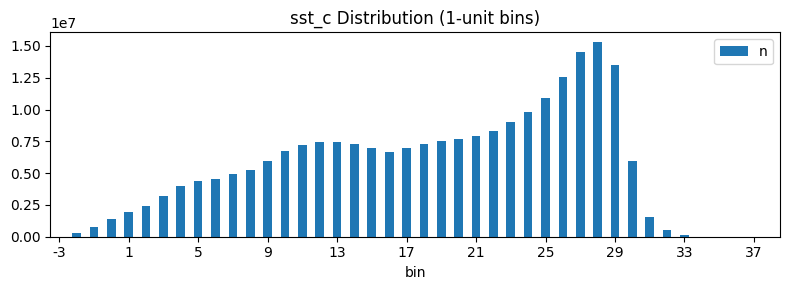

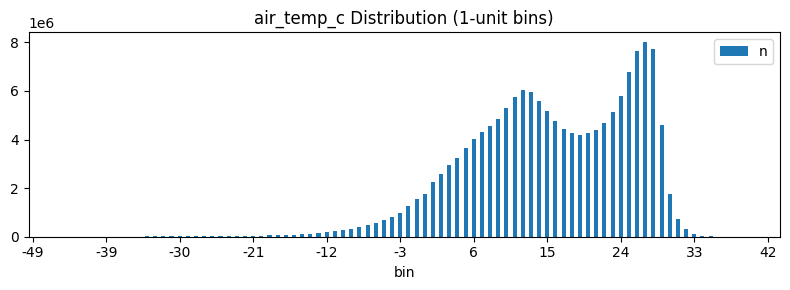

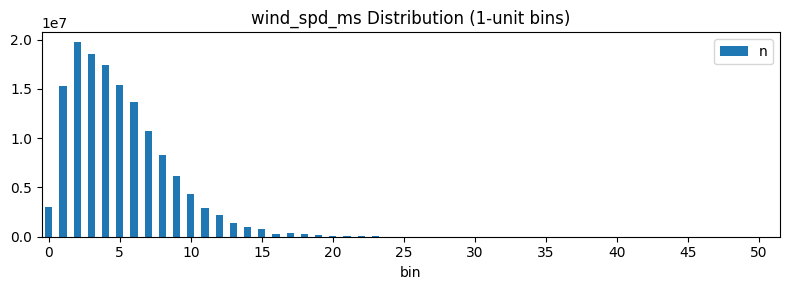

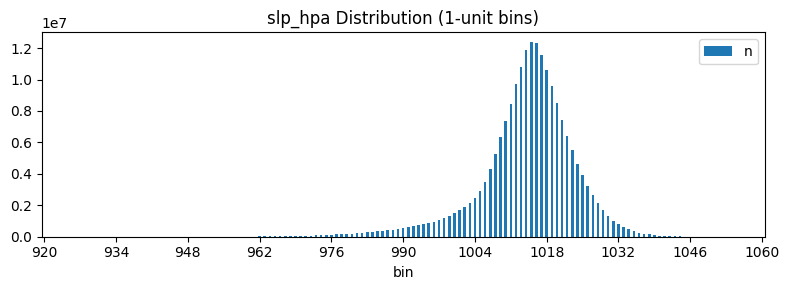

In [ ]:
features = ['sst_c', 'air_temp_c', 'wind_spd_ms', 'slp_hpa']

for f in features:
    df = dist_bins[dist_bins.feature == f]
    if df.empty:
        continue
    ax = df.plot(
        x = "bin", y = "n", kind = "bar", figsize = (8, 3),
        title = f"{f} Distribution (1-unit bins)"
    )
    ticks = ax.get_xticks()
    labels = ax.get_xticklabels()
    step = max(1, len(ticks) // 10)
    ax.set_xticks(ticks[::step])
    ax.set_xticklabels([lab.get_text() for lab in labels][::step], rotation = 0)
    plt.tight_layout()

## QQ

In [ ]:
%%bigquery samp --project icoads-time-series-analysis
SELECT sst_c, air_temp_c, wind_spd_ms, slp_hpa
FROM `icoads-time-series-analysis.icoads_data.icoads_wv`
WHERE yy BETWEEN 2005 AND 2017
    AND RAND() < 0.0005;

Query is running:   0%|          |

Downloading:   0%|          |

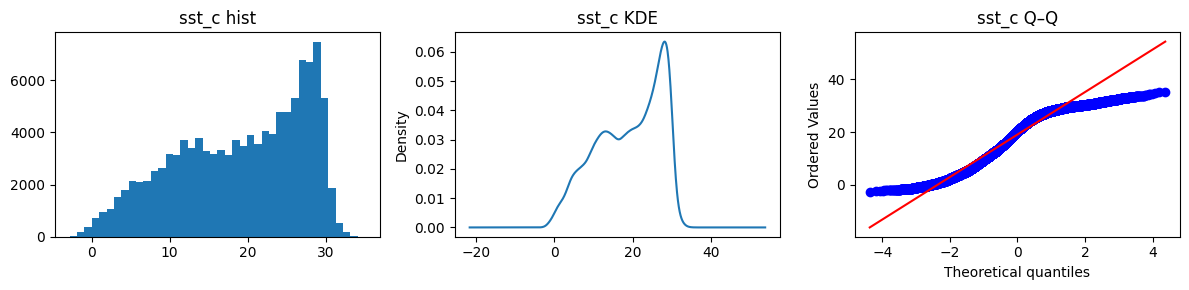

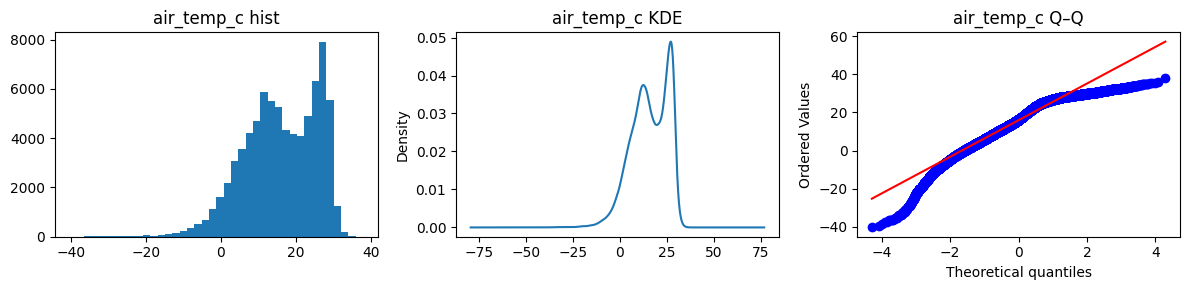

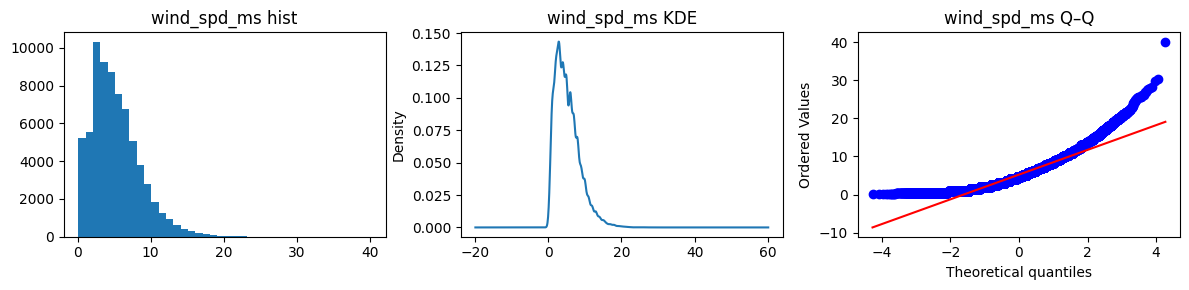

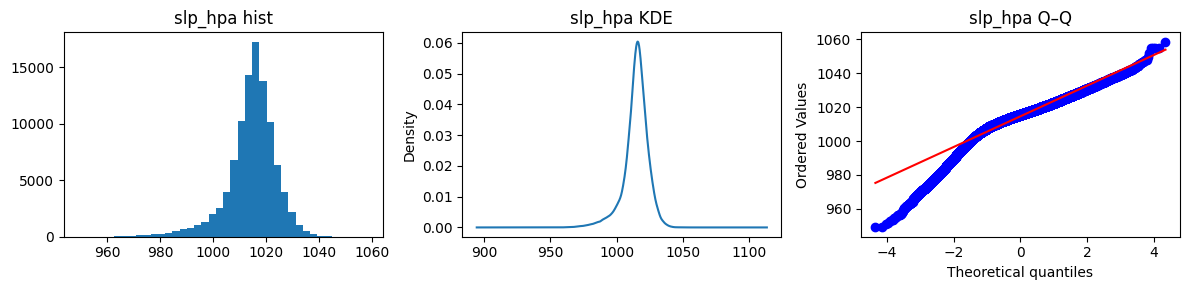

In [ ]:
for f in features:
    s = samp[f].dropna()
    if s.empty:
        continue
    fig, axes = plt.subplots(1, 3, figsize = (12, 3))
    axes[0].hist(s, bins = 40)
    axes[0].set_title(f"{f} hist")
    s.plot(kind = "kde", ax = axes[1])
    axes[1].set_title(f"{f} KDE")
    stats.probplot(s, dist = "norm", plot = axes[2])
    axes[2].set_title(f"{f} Q–Q")
    plt.tight_layout()

1. SST/Air temp ~uni/bi-modal
2. Wind speed skews right
3. SLP pretty normal

# Transformations & New view for cleaned data

In [ ]:
%%bigquery --project icoads-time-series-analysis
CREATE OR REPLACE VIEW `icoads-time-series-analysis.icoads_data.icoads_analysis_wv` AS
SELECT
  *,
  IF(sst_c BETWEEN -2 AND 35, sst_c, NULL) AS sst_cap,
  IF(air_temp_c BETWEEN -40 AND 40, air_temp_c, NULL) AS air_temp_cap,
  IF(wind_spd_ms BETWEEN 0 AND 40, wind_spd_ms, NULL) AS wind_spd_cap,
  IF(wind_spd_ms IS NOT NULL AND wind_spd_ms >= 0, LOG(1 + wind_spd_ms), NULL) AS wind_log,
  GREATEST(slp_hpa, 950) AS slp_wins,
  CASE WHEN air_temp_c < 0 THEN 1 ELSE 0 END AS air_cold_flag,
  CASE WHEN sst_c < 5 THEN 1 ELSE 0 END AS sst_cold_flag
FROM `icoads-time-series-analysis.icoads_data.icoads_wv`;

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project icoads-time-series-analysis
DECLARE cols ARRAY<STRING> DEFAULT ['sst_cap', 'air_temp_cap', 'wind_spd_cap', 'wind_log', 'slp_wins'];
DECLARE start_y INT64 DEFAULT 2005;
DECLARE end_y INT64 DEFAULT 2017;
DECLARE col STRING;

CREATE OR REPLACE TABLE `icoads-time-series-analysis.icoads_data.univ_summary` (
    feature STRING,
    n INT64,
    n_nonnull INT64,
    miss_rate FLOAT64,
    mean FLOAT64,
    stdev FLOAT64,
    min FLOAT64,
    q1 FLOAT64,
    q2 FLOAT64,
    q3 FLOAT64,
    max FLOAT64
);
TRUNCATE TABLE `icoads-time-series-analysis.icoads_data.univ_summary`;

FOR rec IN (SELECT c AS feature FROM UNNEST(cols) AS c) DO
    SET col = rec.feature;
    EXECUTE IMMEDIATE FORMAT("""
        INSERT INTO `icoads-time-series-analysis.icoads_data.univ_summary`
        WITH q AS (
            SELECT APPROX_QUANTILES(%s, 100) AS qt
            FROM `icoads-time-series-analysis.icoads_data.icoads_analysis_wv`
            WHERE yy BETWEEN %d AND %d AND %s IS NOT NULL
        )
        SELECT
        '%s' AS feature,
        COUNT(*) AS n,
        COUNT(%s) AS n_nonnull,
        SAFE_DIVIDE(COUNTIF(%s IS NULL), COUNT(*)) AS miss_rate,
        AVG(%s) AS mean,
        STDDEV(%s) AS stdev,
        MIN(%s) AS min,
        (SELECT qt[OFFSET(25)] FROM q) AS q1,
        (SELECT qt[OFFSET(50)] FROM q) AS q2,
        (SELECT qt[OFFSET(75)] FROM q) AS q3,
        MAX(%s) AS max
        FROM `icoads-time-series-analysis.icoads_data.icoads_analysis_wv`
        WHERE yy BETWEEN %d AND %d
        """, col, start_y, end_y, col, col, col, col, col, col, col, col, start_y, end_y
    );
END FOR;

SELECT * FROM `icoads-time-series-analysis.icoads_data.univ_summary` ORDER BY feature;


Query is running:   0%|          |

Downloading:   0%|          |

,feature,n,n_nonnull,miss_rate,mean,stdev,min,q1,q2,q3,max
0,air_temp_cap,321322074,156349430,0.513418,15.908754,9.811853,-40.00000,9.100000,16.200000,24.700000,40.000000
1,slp_wins,321322074,201827202,0.371885,1014.546209,9.375308,950.00000,1010.600000,1015.500000,1020.000000,1060.000000
2,sst_cap,321322074,228496866,0.288885,19.069064,8.273387,-2.00000,12.500000,20.400000,26.500000,35.000000
3,wind_log,321322074,142109316,0.557736,1.688050,0.551554,0.09531,1.280934,1.722767,2.079442,3.979682
4,wind_spd_cap,321322074,142109217,0.557736,5.255337,3.396353,0.10000,2.600000,4.600000,7.000000,40.000000


In [ ]:
%%bigquery --project icoads-time-series-analysis
WITH vars AS (
    SELECT 'sst_cap' AS feature, sst_cap AS v
    FROM `icoads-time-series-analysis.icoads_data.icoads_analysis_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND sst_cap IS NOT NULL
    UNION ALL
    SELECT 'air_temp_cap', air_temp_cap
    FROM `icoads-time-series-analysis.icoads_data.icoads_analysis_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND air_temp_cap IS NOT NULL
    UNION ALL
    SELECT 'wind_spd_cap', wind_spd_cap
    FROM `icoads-time-series-analysis.icoads_data.icoads_analysis_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND wind_spd_cap IS NOT NULL
    UNION ALL
    SELECT 'wind_log', wind_log
    FROM `icoads-time-series-analysis.icoads_data.icoads_analysis_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND wind_log IS NOT NULL
    UNION ALL
    SELECT 'slp_wins', slp_wins
    FROM `icoads-time-series-analysis.icoads_data.icoads_analysis_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND slp_wins IS NOT NULL
)
SELECT
    feature,
    CAST(FLOOR(v) AS INT64) AS bin,
    COUNT(*) AS n
FROM vars
GROUP BY feature, bin
ORDER BY feature, bin;


Query is running:   0%|          |

Downloading:   0%|          |

,feature,bin,n
0,air_temp_cap,-40,3118
1,air_temp_cap,-39,3486
2,air_temp_cap,-38,4421
3,air_temp_cap,-37,5557
4,air_temp_cap,-36,6913
...,...,...,...
270,wind_spd_cap,36,143
271,wind_spd_cap,37,87
272,wind_spd_cap,38,59
273,wind_spd_cap,39,23


In [ ]:
%%bigquery --project icoads-time-series-analysis
DECLARE cols ARRAY<STRING> DEFAULT ['sst_cap','air_temp_cap','wind_spd_cap','wind_log','slp_wins'];
DECLARE start_y INT64 DEFAULT 2005;
DECLARE end_y INT64 DEFAULT 2017;

CREATE OR REPLACE TABLE `icoads-time-series-analysis.icoads_data.biv_corr_global` (x STRING, y STRING, r FLOAT64);
TRUNCATE TABLE `icoads-time-series-analysis.icoads_data.biv_corr_global`;
CREATE OR REPLACE TABLE `icoads-time-series-analysis.icoads_data.biv_corr_monthly` (x STRING, y STRING, mm INT64, r FLOAT64);
TRUNCATE TABLE `icoads-time-series-analysis.icoads_data.biv_corr_monthly`;

CREATE TEMP TABLE pairs AS
SELECT c1 AS x, c2 AS y
FROM UNNEST(cols) c1 WITH OFFSET i
JOIN UNNEST(cols) c2 WITH OFFSET j ON i < j;

-- global
INSERT INTO `icoads-time-series-analysis.icoads_data.biv_corr_global`
SELECT x, y, CORR(xv, yv) AS r
FROM (SELECT
    CASE x WHEN 'sst_cap' THEN sst_cap
           WHEN 'air_temp_cap' THEN air_temp_cap
           WHEN 'wind_spd_cap' THEN wind_spd_cap
           WHEN 'wind_log' THEN wind_log
           ELSE slp_wins END AS xv,
    CASE y WHEN 'sst_cap' THEN sst_cap
           WHEN 'air_temp_cap' THEN air_temp_cap
           WHEN 'wind_spd_cap' THEN wind_spd_cap
           WHEN 'wind_log' THEN wind_log
           ELSE slp_wins END AS yv,
    x, y FROM `icoads-time-series-analysis.icoads_data.icoads_analysis_wv`
    CROSS JOIN pairs
    WHERE yy BETWEEN start_y AND end_y
) s GROUP BY x, y;

-- monthly
INSERT INTO `icoads-time-series-analysis.icoads_data.biv_corr_monthly`
SELECT x, y, mm, CORR(xv, yv) AS r
FROM (SELECT mm,
    CASE x WHEN 'sst_cap' THEN sst_cap
           WHEN 'air_temp_cap' THEN air_temp_cap
           WHEN 'wind_spd_cap' THEN wind_spd_cap
           WHEN 'wind_log' THEN wind_log
           ELSE slp_wins END AS xv,
    CASE y WHEN 'sst_cap' THEN sst_cap
           WHEN 'air_temp_cap' THEN air_temp_cap
           WHEN 'wind_spd_cap' THEN wind_spd_cap
           WHEN 'wind_log' THEN wind_log
           ELSE slp_wins END AS yv,
    x, y FROM `icoads-time-series-analysis.icoads_data.icoads_analysis_wv`
    CROSS JOIN pairs
    WHERE yy BETWEEN start_y AND end_y
) s
GROUP BY x, y, mm
ORDER BY x, y, mm;

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project icoads-time-series-analysis
CREATE OR REPLACE TABLE `icoads-time-series-analysis.icoads_data.grid_1deg_monthly_clean` AS
SELECT
    d_month,
    CAST(FLOOR(latitude) AS INT64) AS lat1,
    CAST(FLOOR(longitude) AS INT64) AS lon1,
    AVG(sst_cap) AS sst_mean,
    AVG(air_temp_cap) AS air_mean,
    AVG(wind_spd_cap) AS wind_mean,
    COUNT(*) AS n
FROM `icoads-time-series-analysis.icoads_data.icoads_analysis_wv`
WHERE yy BETWEEN 2005 AND 2017
GROUP BY d_month, lat1, lon1;

Query is running:   0%|          |

""


## Missing rate

In [ ]:
%%bigquery uni --project icoads-time-series-analysis
SELECT * FROM `icoads-time-series-analysis.icoads_data.univ_summary`
ORDER BY feature;

Query is running:   0%|          |

Downloading:   0%|          |

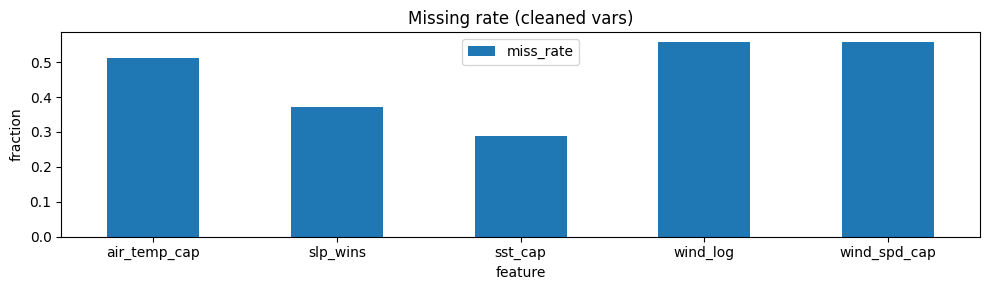

In [ ]:
ax = uni.plot(
    x = "feature", y = "miss_rate",
    kind = "bar", rot = 0, figsize = (10, 3),
    title = "Missing rate (cleaned vars)"
)
ax.set_ylabel("fraction");
plt.tight_layout()

## Histograms

In [ ]:
%%bigquery h --project icoads-time-series-analysis
WITH vars AS (
    SELECT 'sst_cap' AS feature, sst_cap AS v
    FROM `icoads-time-series-analysis.icoads_data.icoads_analysis_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND sst_cap IS NOT NULL
    UNION ALL
    SELECT 'air_temp_cap', air_temp_cap AS v
    FROM `icoads-time-series-analysis.icoads_data.icoads_analysis_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND air_temp_cap IS NOT NULL
    UNION ALL
    SELECT 'wind_spd_cap', wind_spd_cap AS v
    FROM `icoads-time-series-analysis.icoads_data.icoads_analysis_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND wind_spd_cap IS NOT NULL
    UNION ALL
    SELECT 'wind_log', wind_log AS v
    FROM `icoads-time-series-analysis.icoads_data.icoads_analysis_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND wind_log IS NOT NULL
    UNION ALL
    SELECT 'slp_wins', slp_wins AS v
    FROM `icoads-time-series-analysis.icoads_data.icoads_analysis_wv`
    WHERE yy BETWEEN 2005 AND 2017 AND slp_wins IS NOT NULL
)
SELECT
    feature,
    CAST(FLOOR(v) AS INT64) AS bin,
    COUNT(*) AS n
FROM vars
GROUP BY feature, bin
ORDER BY feature, bin;


Query is running:   0%|          |

Downloading:   0%|          |

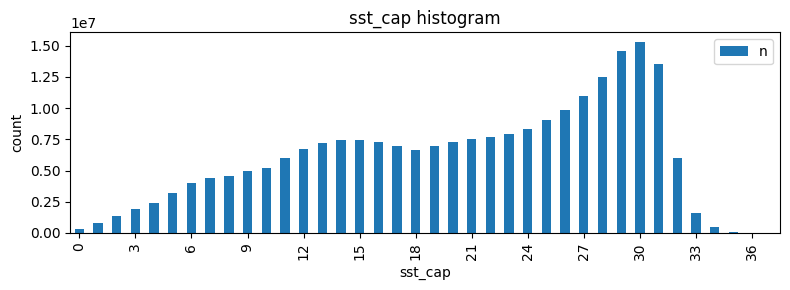

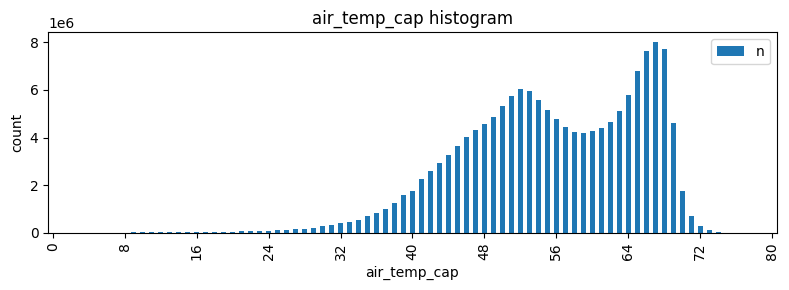

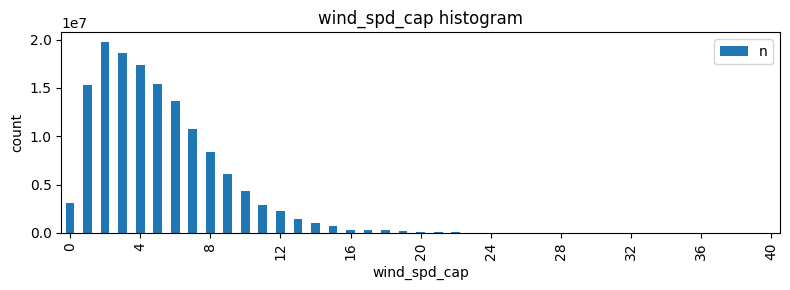

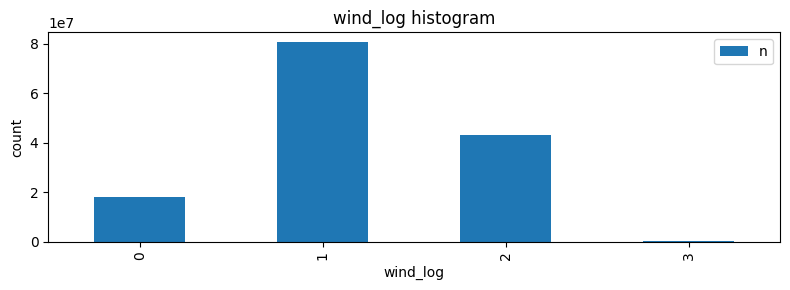

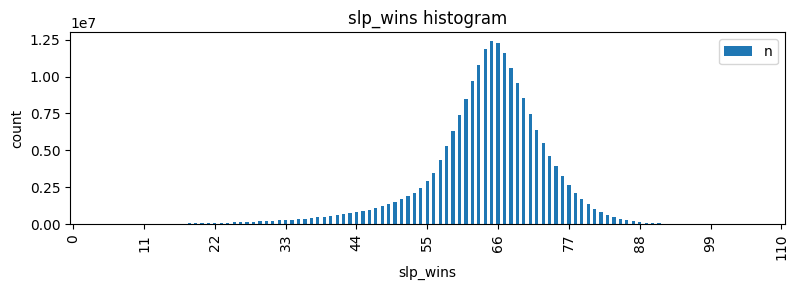

In [ ]:
features = ['sst_cap', 'air_temp_cap', 'wind_spd_cap', 'wind_log', 'slp_wins']

for f in features:
    df = h[h.feature == f]
    if df.empty:
        continue
    ax = df.plot(
        x = "bin", y = "n",
        kind = "bar", figsize = (8, 3),
        title = f"{f} histogram"
    )
    ticks = ax.get_xticks()
    step = max(1, len(ticks) // 10)
    ax.set_xticks(ticks[::step])
    ax.set_xticklabels([int(t) for t in ticks[::step]])
    ax.set_xlabel(f)
    ax.set_ylabel("count")
    plt.tight_layout()

## Correlations

In [ ]:
%%bigquery corr_g --project icoads-time-series-analysis
SELECT * FROM `icoads-time-series-analysis.icoads_data.biv_corr_global`
ORDER BY ABS(r) DESC;

Query is running:   0%|          |

Downloading:   0%|          |

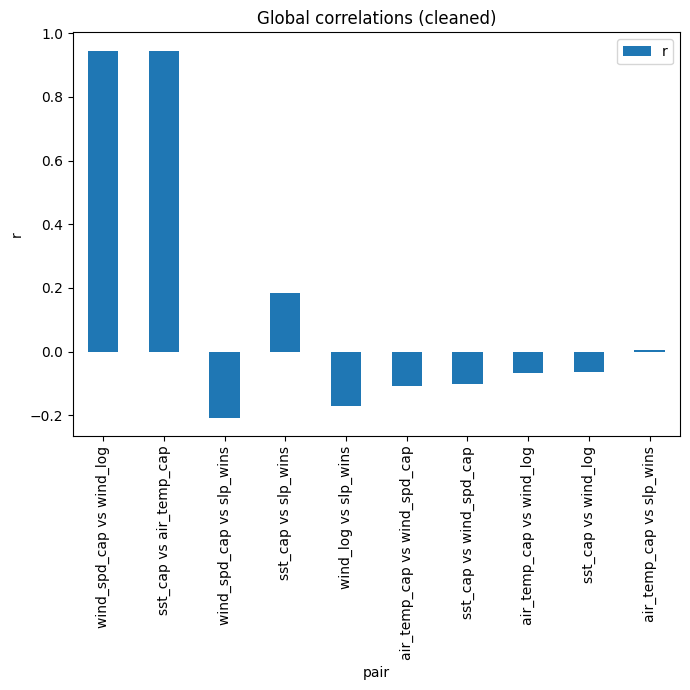

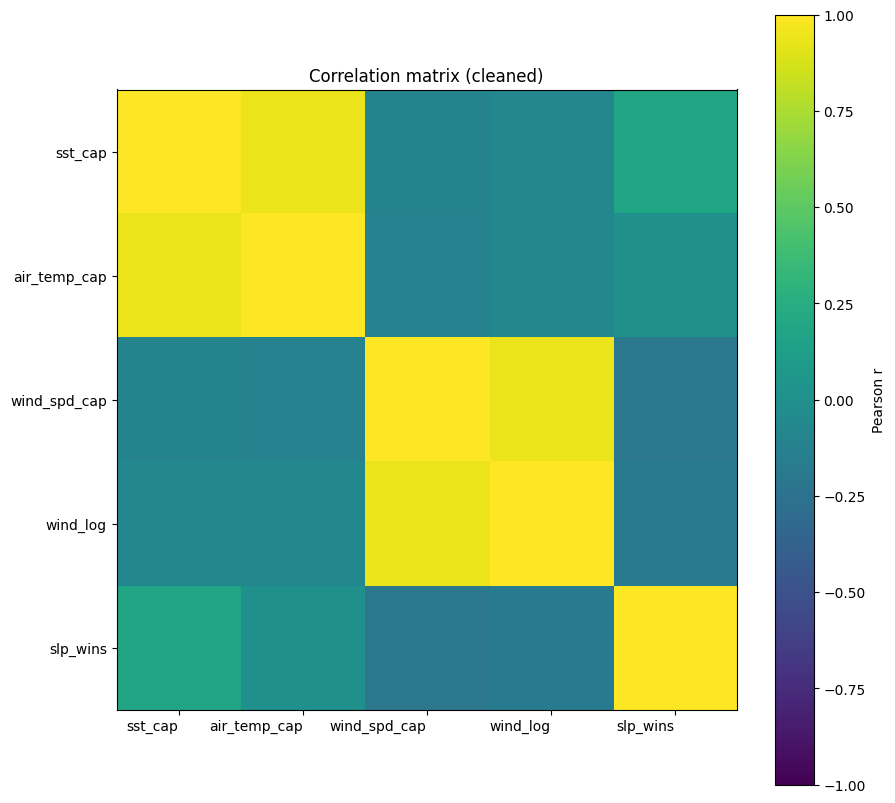

In [ ]:
corr_g["pair"] = corr_g["x"] + " vs " + corr_g["y"]
ax = corr_g.plot(
    x = "pair", y = "r",
    kind = "bar", rot = 90, figsize = (7, 7),
    title = "Global correlations (cleaned)"
)
ax.set_ylabel("r");
plt.tight_layout()

# heatmap
mat = pd.DataFrame(np.eye(len(features)), index = features, columns = features)
for _,row in corr_g.iterrows():
    mat.loc[row.x, row.y] = row.r
    mat.loc[row.y, row.x] = row.r
plt.figure(figsize=(10, 10))
im = plt.imshow(mat.values, vmin = -1, vmax = 1)
plt.xticks(range(len(features)), features, rotation = 0, ha = "right")
plt.yticks(range(len(features)), features)
cbar = plt.colorbar(im);
cbar.set_label("Pearson r")
plt.title("Correlation matrix (cleaned)");

## Spatial

In [ ]:
%%bigquery grid_all --project icoads-time-series-analysis
SELECT
    lat1, lon1,
    AVG(sst_mean) AS sst_all,
    AVG(air_mean) AS air_all,
    AVG(wind_mean) AS wind_all
FROM `icoads-time-series-analysis.icoads_data.grid_1deg_monthly_clean`
GROUP BY lat1, lon1;

Query is running:   0%|          |

Downloading:   0%|          |

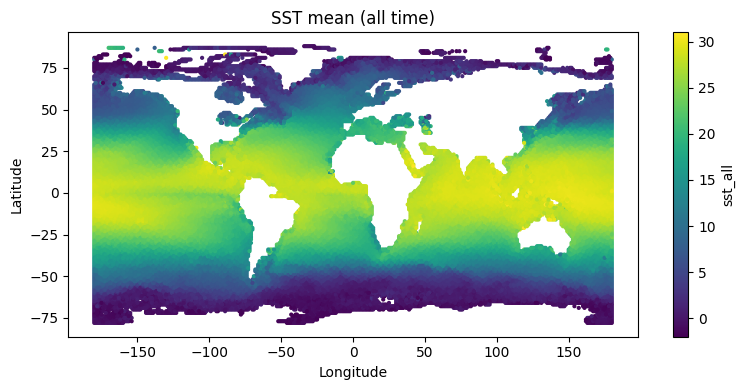

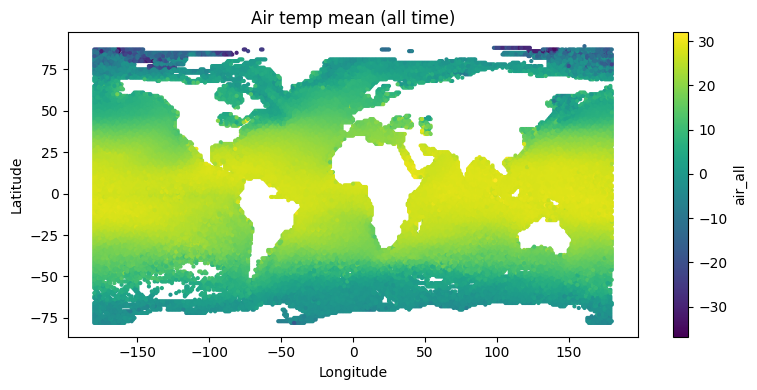

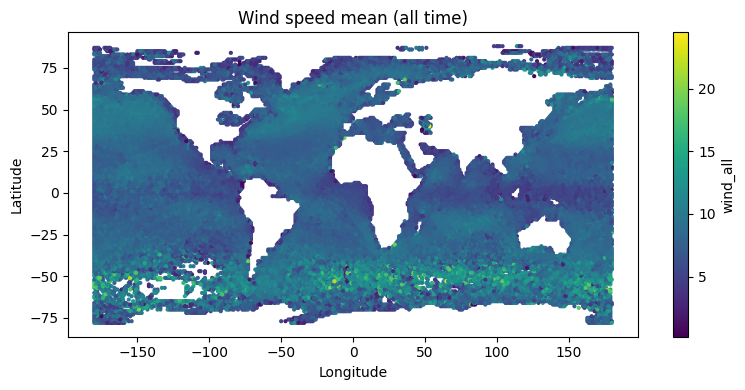

In [ ]:
def plot_field(df, field, title):
    ax = df.plot.scatter(
        x = "lon1", y = "lat1",
        s = 4, c = field, colorbar = False,
        figsize = (8, 4), title = title
    )
    m = ax.collections[0]
    cbar = ax.figure.colorbar(m, ax = ax)
    cbar.set_label(field)
    ax.set_xlabel("Longitude");
    ax.set_ylabel("Latitude")
    plt.tight_layout()

plot_field(grid_all, "sst_all", "SST mean (all time)")
plot_field(grid_all, "air_all", "Air temp mean (all time)")
plot_field(grid_all, "wind_all", "Wind speed mean (all time)")

# Cleaned/transformed

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `icoads-time-series-analysis.icoads_data.icoads_final`
PARTITION BY RANGE_BUCKET(yy, GENERATE_ARRAY(2005, 2018, 1))
CLUSTER BY lat1, lon1 AS
SELECT
    unique_report_id,
    timestamp,
    yy,
    mm,
    d_month,
    latitude,
    longitude,
    CAST(FLOOR(latitude)  AS INT64) AS lat1,
    CAST(FLOOR(longitude) AS INT64) AS lon1,
    sst_c,
    air_temp_c,
    wind_spd_ms,
    slp_hpa,
    IF(sst_c BETWEEN -2 AND 35, sst_c, NULL) AS sst_cap,
    IF(air_temp_c BETWEEN -40 AND 40, air_temp_c, NULL) AS air_temp_cap,
    IF(wind_spd_ms BETWEEN 0 AND 40, wind_spd_ms, NULL) AS wind_spd_cap,
    IF(wind_spd_ms IS NOT NULL AND wind_spd_ms >= 0, LOG(1 + wind_spd_ms), NULL) AS wind_log,
    GREATEST(slp_hpa, 950) AS slp_wins
FROM `icoads-time-series-analysis.icoads_data.icoads_wv`;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

# SST Correlations

In [ ]:
%%bigquery --project icoads-time-series-analysis
DECLARE src_table STRING DEFAULT "icoads-time-series-analysis.icoads_data.icoads_raw_aggregated";
DECLARE start_year INT64 DEFAULT 2005;
DECLARE end_year INT64 DEFAULT 2017;
DECLARE col_name STRING;
DECLARE col_type STRING;
DECLARE expr STRING;

CREATE OR REPLACE TABLE `icoads-time-series-analysis.icoads_data.sst_corr_all` (
    feature STRING,
    corr FLOAT64,
    n_used INT64
);
TRUNCATE TABLE `icoads-time-series-analysis.icoads_data.sst_corr_all`;

INSERT INTO `icoads-time-series-analysis.icoads_data.sst_corr_all`
SELECT 'sea_surface_temp' AS feature, 1.0 AS corr, COUNTIF(sea_surface_temp IS NOT NULL) AS n_used
FROM `icoads-time-series-analysis.icoads_data.icoads_raw_aggregated`
WHERE year BETWEEN start_year AND end_year;

FOR rec IN (
    SELECT column_name, data_type
    FROM `icoads-time-series-analysis.icoads_data`.INFORMATION_SCHEMA.COLUMNS
    WHERE table_name = 'icoads_raw_aggregated' AND column_name != 'sea_surface_temp'
) DO
    SET col_name = rec.column_name;
    SET col_type = rec.data_type;

    IF col_type IN ('INT64','FLOAT64','NUMERIC','BIGNUMERIC') THEN
        SET expr = FORMAT("CAST(%s AS FLOAT64)", col_name);
    ELSEIF col_type = 'TIMESTAMP' THEN
        SET expr = FORMAT("CAST(UNIX_SECONDS(%s) AS FLOAT64)", col_name);
    ELSEIF col_type = 'DATETIME' THEN
        SET expr = FORMAT("CAST(UNIX_SECONDS(TIMESTAMP(%s)) AS FLOAT64)", col_name);
    ELSEIF col_type = 'DATE' THEN
        SET expr = FORMAT("CAST(UNIX_DATE(%s) AS FLOAT64)", col_name);
    ELSE
        SET expr = FORMAT("SAFE_CAST(%s AS FLOAT64)", col_name);
    END IF;

    EXECUTE IMMEDIATE FORMAT("""
        INSERT INTO `icoads-time-series-analysis.icoads_data.sst_corr_all`
        WITH base AS (
            SELECT
                NULLIF(sea_surface_temp, 99.9) AS sst,
                %s AS v
            FROM `%s`
            WHERE year BETWEEN %d AND %d
        )
        SELECT
        '%s' AS feature,
        CORR(sst, v) AS corr,
        COUNTIF(sst IS NOT NULL AND v IS NOT NULL) AS n_used
        FROM base
        """, expr, src_table, start_year, end_year, col_name
    );
END FOR;

SELECT *
FROM `icoads-time-series-analysis.icoads_data.sst_corr_all`
ORDER BY ABS(corr) DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,feature,corr,n_used
0,sea_surface_temp,1.000000,228505759
1,air_temperature,0.943968,92044765
2,wetbulb_temperature,0.932716,7213088
3,dewpoint_temperature,0.899776,27894271
4,dpt_indicator,0.436896,7315934
...,...,...,...
70,swell_period_indicator,NaN,0
71,pressure_bias,NaN,0
72,box_system_indicator,NaN,0
73,wave_period_indicator,NaN,0


In [ ]:
%%bigquery sst_corr_all --project icoads-time-series-analysis
SELECT * FROM `icoads-time-series-analysis.icoads_data.sst_corr_all`
ORDER BY ABS(corr) DESC;

Query is running:   0%|          |

Downloading:   0%|          |

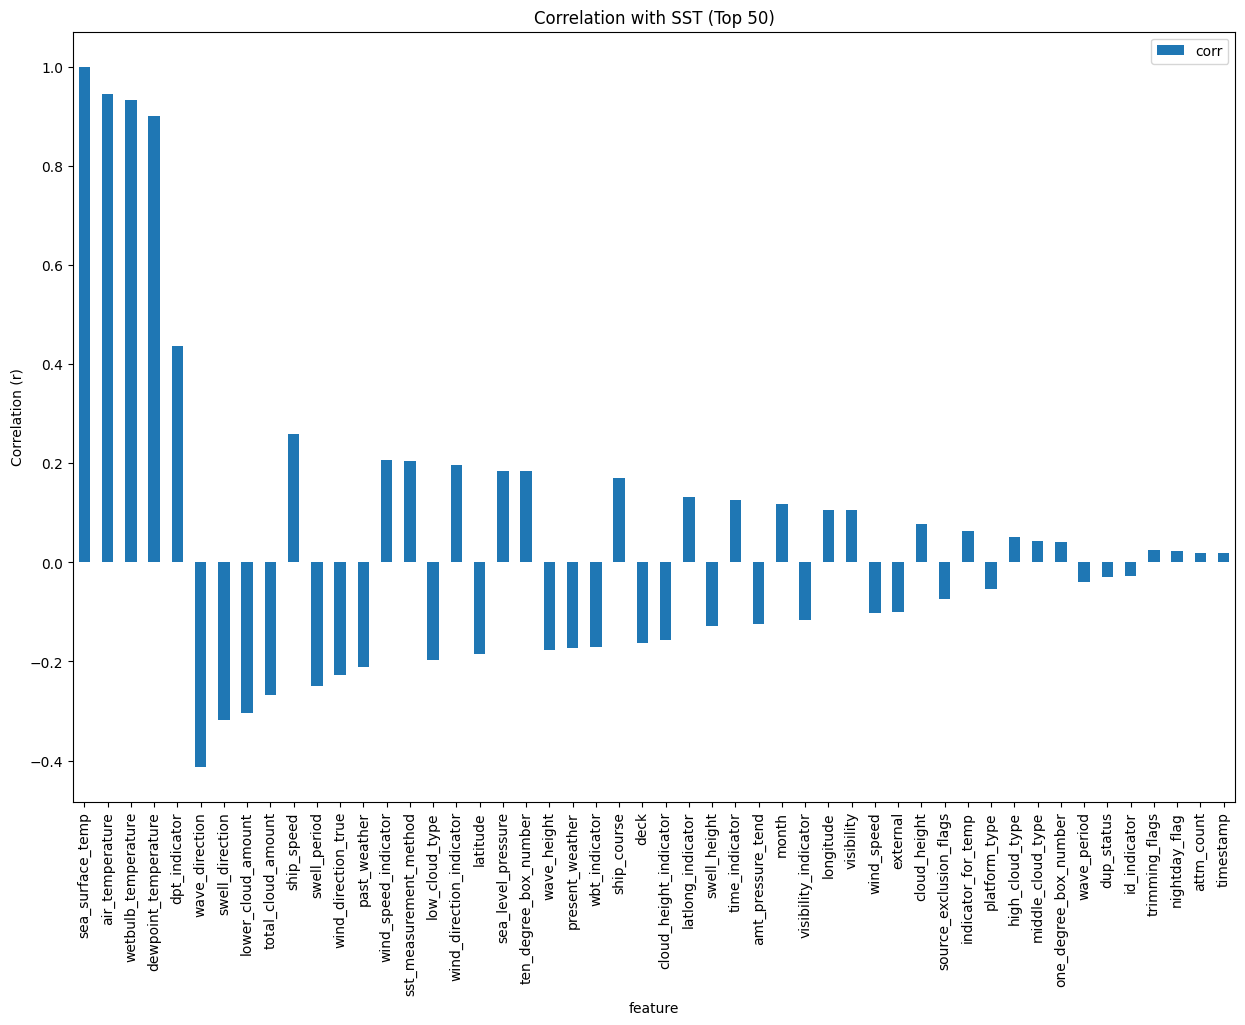

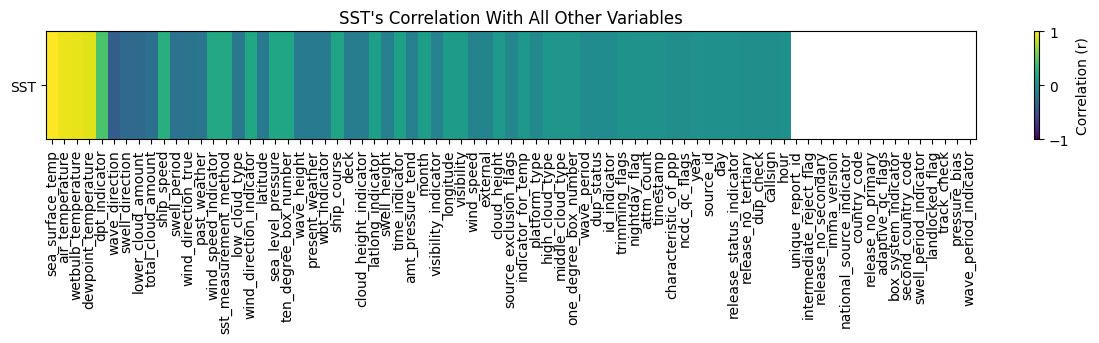

In [ ]:
top = sst_corr_all.head(50)
ax = top.plot(
    x = "feature", y = "corr",
    kind = "bar", figsize = (15, 10), rot = 90,
    title = "Correlation with SST (Top 50)"
)
ax.set_ylabel("Correlation (r)")
features = sst_corr_all["feature"].tolist()
vals = sst_corr_all["corr"].to_numpy()[None, :]
plt.figure(figsize = (max(10, len(features) * 0.2), 1.4))
im = plt.imshow(vals, vmin = -1, vmax = 1, aspect = "auto")
plt.yticks([0], ["SST"])
plt.xticks(range(len(features)), features, rotation = 90)
cbar = plt.colorbar(im);
cbar.set_label("Correlation (r)")
plt.title("SST's Correlation With All Other Variables");

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
DROP TABLE IF EXISTS `icoads-time-series-analysis.icoads_data.icoads_raw_aggregated_no_temps`;
CREATE TABLE `icoads-time-series-analysis.icoads_data.icoads_raw_aggregated_no_temps`
PARTITION BY RANGE_BUCKET(year, GENERATE_ARRAY(2005, 2018, 1)) AS
SELECT
    * EXCEPT (
        air_temperature,
        wetbulb_temperature,
        dewpoint_temperature
    )
FROM `icoads-time-series-analysis.icoads_data.icoads_raw_aggregated`;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

# Checking missing deps
- Only some vars

In [ ]:
%%bigquery --project icoads-time-series-analysis
CREATE OR REPLACE VIEW `icoads-time-series-analysis.icoads_data.miss_view` AS
SELECT
    unique_report_id,
    sea_surface_temp,
    air_temperature,
    dewpoint_temperature,
    wetbulb_temperature,
    wind_speed,
    sea_level_pressure,
    visibility,
    wave_height,
    wave_period,
    swell_height,
    IF(sea_surface_temp IS NULL, 1, 0) AS m_sst,
    IF(air_temperature IS NULL, 1, 0) AS m_air,
    IF(dewpoint_temperature IS NULL, 1, 0) AS m_dew,
    IF(wetbulb_temperature IS NULL, 1, 0) AS m_wbt,
    IF(wind_speed IS NULL, 1, 0) AS m_wind,
    IF(sea_level_pressure IS NULL, 1, 0) AS m_slp,
    IF(visibility IS NULL, 1, 0) AS m_vis,
    IF(wave_height IS NULL, 1, 0) AS m_waveh,
    IF(wave_period IS NULL, 1, 0) AS m_wavep,
    IF(swell_height IS NULL, 1, 0) AS m_swellh
FROM `icoads-time-series-analysis.icoads_data.icoads_raw_aggregated`;

Query is running:   0%|          |

""


In [ ]:
%%bigquery miss_pairs --project icoads-time-series-analysis
WITH m AS (
    SELECT m_sst, m_air, m_dew, m_wbt, m_wind, m_slp, m_vis, m_waveh, m_wavep, m_swellh
    FROM `icoads-time-series-analysis.icoads_data.miss_view`
)
SELECT 'sst~air' AS pair, m_sst AS m1, m_air AS m2, COUNT(*) AS n FROM m GROUP BY pair, m1, m2
UNION ALL
SELECT 'sst~dew', m_sst, m_dew, COUNT(*) FROM m GROUP BY 1, 2, 3
UNION ALL
SELECT 'sst~wbt', m_sst, m_wbt, COUNT(*) FROM m GROUP BY 1, 2, 3
UNION ALL
SELECT 'sst~wind', m_sst, m_wind, COUNT(*) FROM m GROUP BY 1, 2, 3
UNION ALL
SELECT 'sst~slp', m_sst, m_slp, COUNT(*) FROM m GROUP BY 1, 2, 3
UNION ALL
SELECT 'sst~vis', m_sst, m_vis, COUNT(*) FROM m GROUP BY 1, 2, 3
UNION ALL
SELECT 'sst~waveh', m_sst, m_waveh, COUNT(*) FROM m GROUP BY 1, 2, 3
UNION ALL
SELECT 'sst~wavep', m_sst, m_wavep, COUNT(*) FROM m GROUP BY 1, 2, 3
UNION ALL
SELECT 'sst~swellh', m_sst, m_swellh, COUNT(*) FROM m GROUP BY 1, 2, 3
ORDER BY pair, m1, m2;


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
pairs = miss_pairs['pair'].unique()
for p in pairs:
    sub = miss_pairs[miss_pairs['pair'] == p]
    tab = pd.pivot_table(sub, values = 'n', index = 'm1', columns = 'm2', fill_value = 0)
    tab = tab.astype(int)
    chi2, pval, dof, exp = chi2_contingency(tab.values)
    print(f'{p} | p: {pval}')

sst~air | p: 0.0
sst~dew | p: 0.0
sst~slp | p: 0.0
sst~swellh | p: 0.0
sst~vis | p: 0.0
sst~waveh | p: 0.0
sst~wavep | p: 0.0
sst~wbt | p: 0.0
sst~wind | p: 0.0


In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
    CONCAT(
        CAST(IF(sea_surface_temp IS NULL,1,0) AS STRING),
        CAST(IF(air_temperature IS NULL,1,0) AS STRING),
        CAST(IF(dewpoint_temperature IS NULL,1,0) AS STRING),
        CAST(IF(wetbulb_temperature IS NULL,1,0) AS STRING),
        CAST(IF(wind_speed IS NULL,1,0) AS STRING),
        CAST(IF(sea_level_pressure IS NULL,1,0) AS STRING),
        CAST(IF(visibility IS NULL,1,0) AS STRING),
        CAST(IF(wave_height IS NULL,1,0) AS STRING),
        CAST(IF(wave_period IS NULL,1,0) AS STRING),
        CAST(IF(swell_height IS NULL,1,0) AS STRING)
    ) AS miss_pattern,
    COUNT(*) AS n
FROM `icoads-time-series-analysis.icoads_data.icoads_raw_aggregated`
WHERE year BETWEEN 2005 AND 2017
GROUP BY miss_pattern
ORDER BY n DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=792, table_html='<table border="1" class="dataframe table table-striped ta…

Computation deferred. Computation will process 28.5 kB

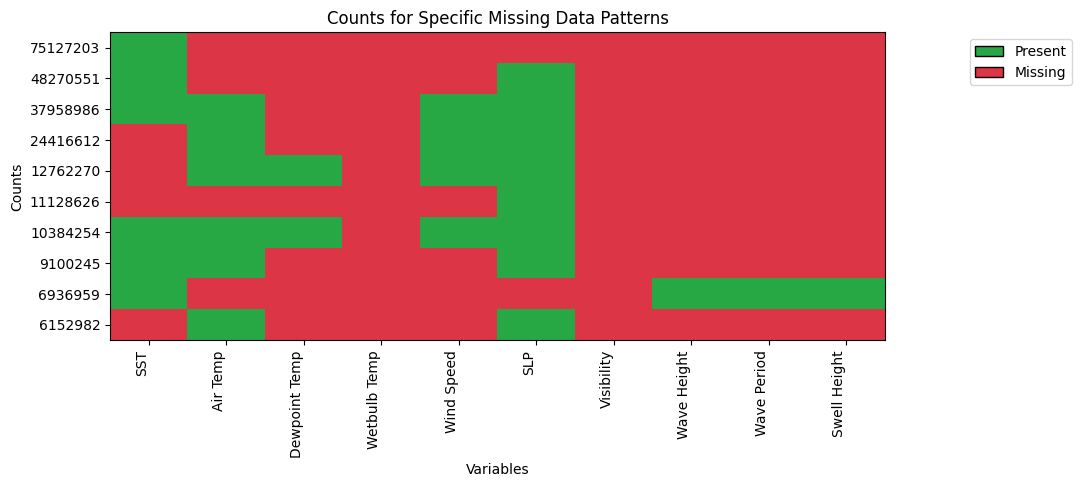

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

data = [
    ("0111111111", 75127203),
    ("0111101111", 48270551),
    ("0011001111", 37958986),
    ("1011001111", 24416612),
    ("1001001111", 12762270),
    ("1111101111", 11128626),
    ("0001001111", 10384254),
    ("0011101111", 9100245),
    ("0111111000", 6936959),
    ("1011101111", 6152982),
]
df = pd.DataFrame(data, columns=["miss_pattern", "n"])
cols = [
    "SST", "Air Temp", "Dewpoint Temp", "Wetbulb Temp", "Wind Speed",
    "SLP", "Visibility", "Wave Height", "Wave Period", "Swell Height"
]
m = df["miss_pattern"].apply(lambda s: pd.Series(list(s))).astype(int)
m.columns = cols
m = pd.concat([df["n"], m], axis=1).sort_values("n", ascending=False)
plt.figure(figsize=(10, 4))
cmap = ListedColormap(["#28a745", "#dc3545"])
plt.imshow(m[cols], aspect="auto", cmap=cmap, vmin=0, vmax=1)
plt.yticks(range(len(m)), m["n"])
plt.xticks(range(len(cols)), cols, rotation=90, ha="right")
plt.ylabel("Counts")
plt.xlabel("Variables")
plt.title("Counts for Specific Missing Data Patterns")
legend_elements = [
    Patch(facecolor="#28a745", edgecolor='k', label="Present"),
    Patch(facecolor="#dc3545", edgecolor='k', label="Missing"),
]
plt.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1.25, 1))
plt.show()

- There are `75m` reports only containing SST (and not the other 9 vars)
- A lot of reports are sparse and only contain certain patterns

## Overall missing status, comping all pairs

- Already know that global MCAR is impossible (above)
- Some variables might be NMAR

In [ ]:
%%bigquery --project icoads-time-series-analysis
DECLARE src_table STRING DEFAULT "icoads-time-series-analysis.icoads_data.icoads_raw_aggregated";
DECLARE dyn_sql STRING;

SET dyn_sql = (
    SELECT FORMAT("""
            CREATE OR REPLACE VIEW `icoads-time-series-analysis.icoads_data.miss_flags_all` AS
            SELECT %s FROM `%s`
        """,
        STRING_AGG(
            FORMAT("IF(%s IS NULL, 1, 0) AS m_%s", column_name, column_name),
            ",\n      "
        ),
        src_table
    )
    FROM `icoads-time-series-analysis.icoads_data`.INFORMATION_SCHEMA.COLUMNS
    WHERE table_name = 'icoads_raw_aggregated'
);
EXECUTE IMMEDIATE dyn_sql;

Query is running:   0%|          |

""


In [ ]:
%%bigquery miss_rows --project icoads-time-series-analysis
SELECT * FROM `icoads-time-series-analysis.icoads_data.miss_flags_all`
WHERE RAND() < 0.001;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
flag_cols = [c for c in miss_rows.columns if c.startswith("m_")]

rows = []
for a, b in combinations(flag_cols, 2):
    tab = pd.crosstab(miss_rows[a], miss_rows[b])
    tab = tab.reindex(index = [0, 1], columns = [0, 1], fill_value = 0).astype(int)
    if (tab.values.sum(axis=1) == 0).any() or (tab.values.sum(axis = 0) == 0).any():
        rows.append({"var1": a[2:], "var2": b[2:], "pval": None, "note": "degenerate"})
        continue
    try:
        chi2, pval, dof, exp = chi2_contingency(tab.values)
        rows.append({"var1": a[2:], "var2": b[2:], "pval": pval, "note": ""})
    except ValueError:
        rows.append({"var1": a[2:], "var2": b[2:], "pval": None, "note": "expected = 0"})

res_df = pd.DataFrame(rows).sort_values(
    ["pval"],
    na_position = "last",
    ignore_index = True
)
res_df.head(50)

,var1,var2,pval,note
0,past_weather,sea_level_pressure,0.0,
1,visibility,dup_check,0.0,
2,visibility,swell_height,0.0,
3,past_weather,wetbulb_temperature,0.0,
4,past_weather,wbt_indicator,0.0,
5,past_weather,air_temperature,0.0,
6,past_weather,indicator_for_temp,0.0,
7,past_weather,amt_pressure_tend,0.0,
8,past_weather,characteristic_of_ppp,0.0,
9,visibility,source_exclusion_flags,0.0,


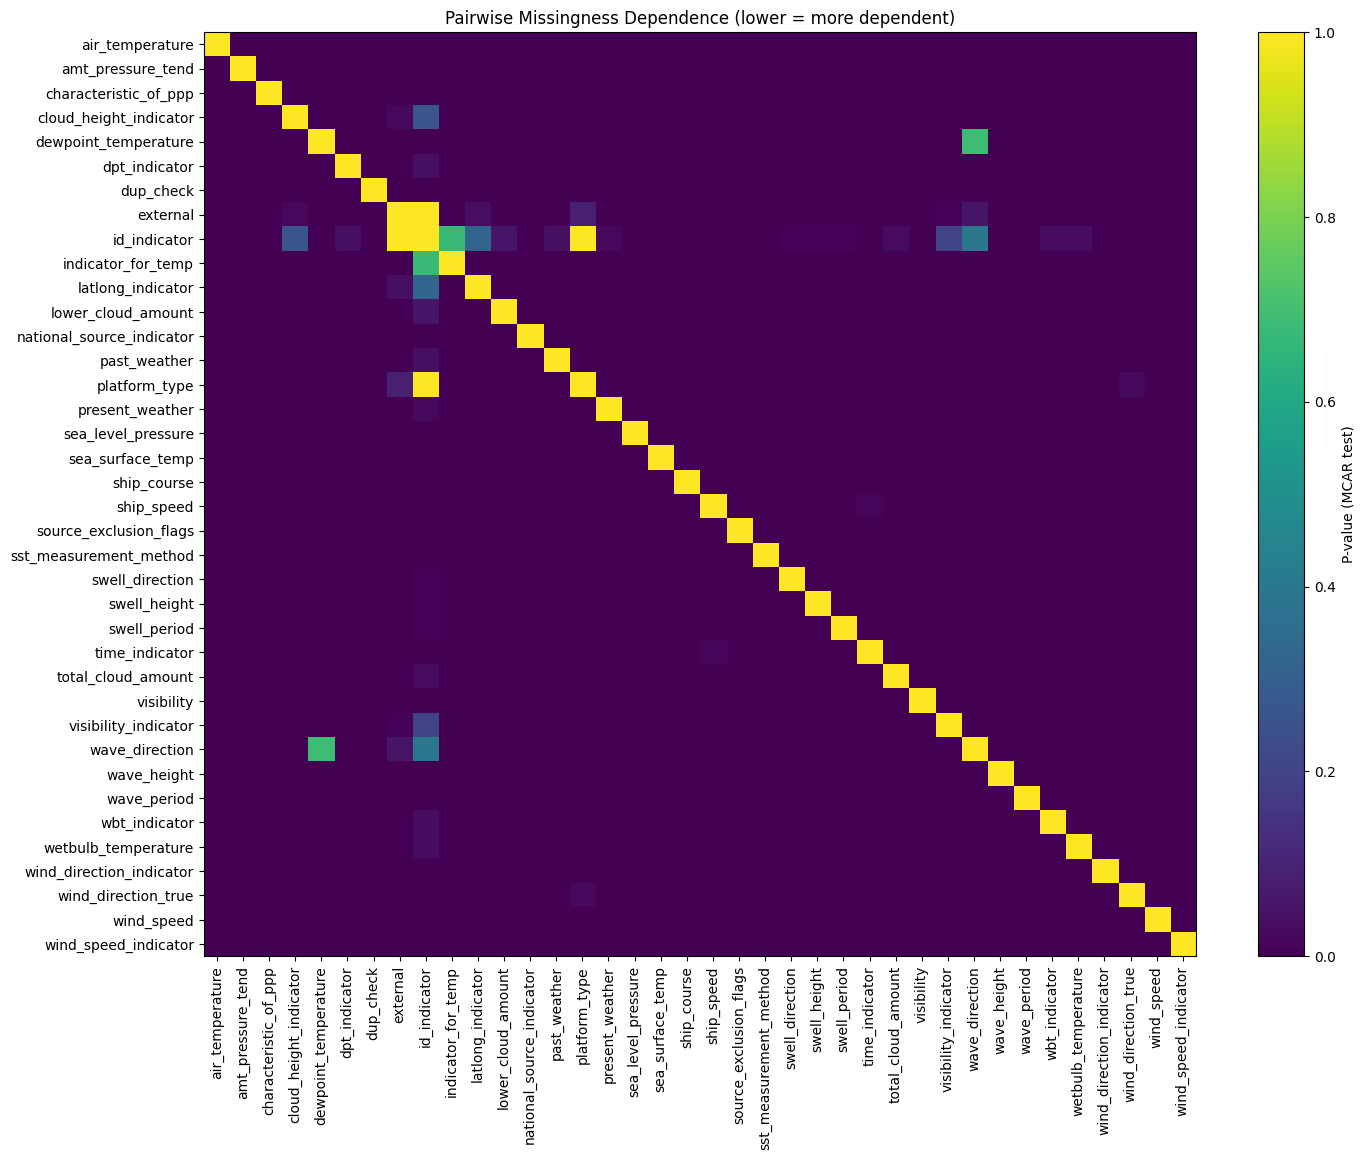

In [ ]:
df = res_df.copy()
df = df[df["pval"].notna()].copy()
vars_ = sorted(set(df["var1"]).union(df["var2"]))
mat = pd.DataFrame(1.0, index = vars_, columns = vars_)

for _, r in df.iterrows():
    v1, v2, p = r["var1"], r["var2"], r["pval"]
    mat.loc[v1, v2] = p
    mat.loc[v2, v1] = p

plt.figure(figsize=(16, 12))
im = plt.imshow(mat.values, vmin = 0, vmax = 1, aspect = "auto")
plt.xticks(range(len(vars_)), vars_, rotation = 90)
plt.yticks(range(len(vars_)), vars_)
cbar = plt.colorbar(im)
cbar.set_label("P-value (MCAR test)")
plt.title("Pairwise Missingness Dependence (lower = more dependent)");


P values are 0 basically for all pairs

Therefore not MCAR

# SST Visualizations

In [ ]:
%%bigquery sst_m --project icoads-time-series-analysis
SELECT
    DATE_TRUNC(timestamp, MONTH) AS d_month,
    AVG(sea_surface_temp) AS sst_mean
FROM `icoads-time-series-analysis.icoads_data.icoads_raw_aggregated`
WHERE sea_surface_temp IS NOT NULL
GROUP BY d_month
ORDER BY d_month;

Query is running:   0%|          |

Downloading:   0%|          |

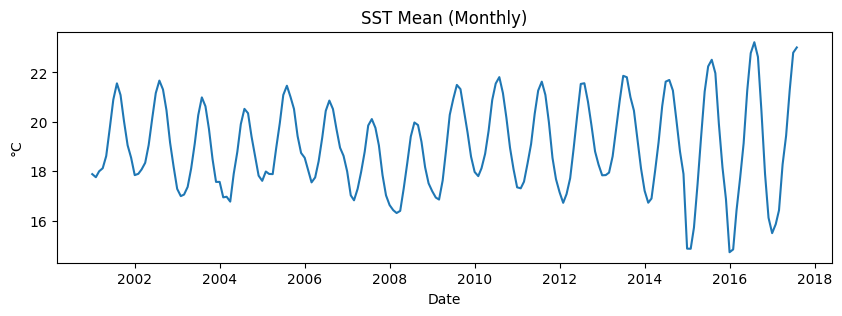

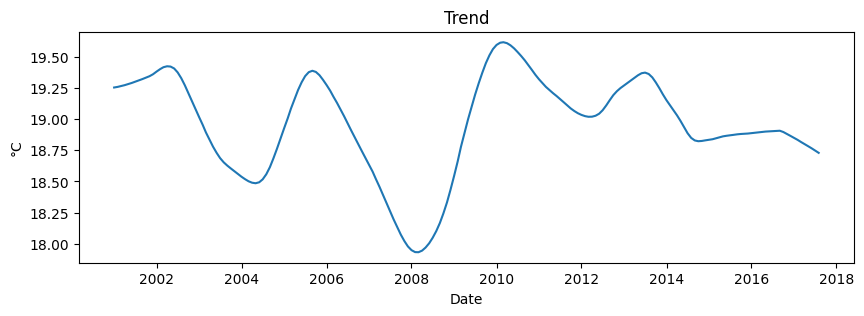

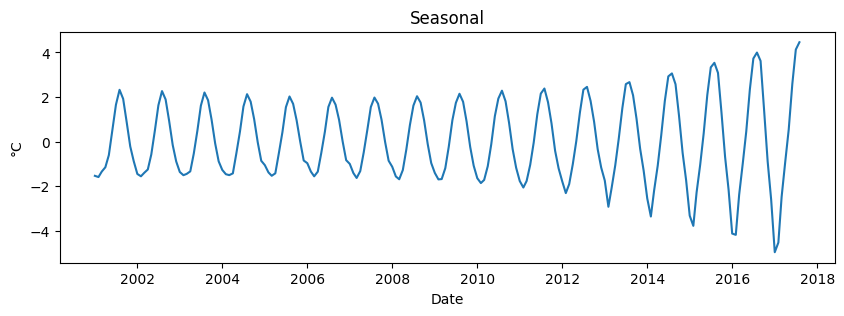

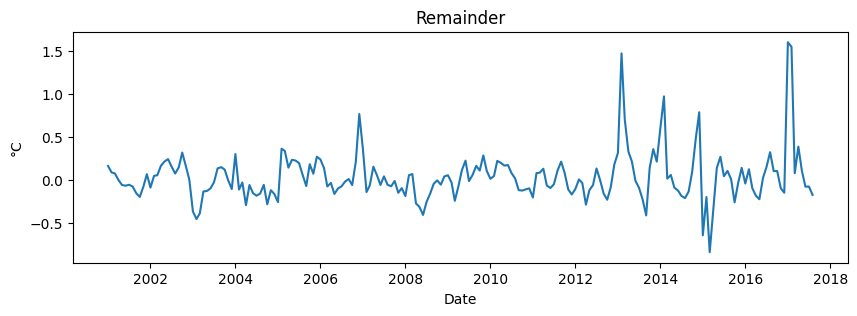

In [ ]:
from statsmodels.tsa.seasonal import STL
sst_m = sst_m.set_index('d_month').asfreq('MS')
sst_m['sst_mean'] = sst_m['sst_mean'].interpolate()
stl = STL(sst_m['sst_mean'], period = 12, robust = True)
res = stl.fit()

plt.figure(figsize = (10, 3))
plt.plot(sst_m.index, sst_m['sst_mean'])
plt.title('SST Mean (Yearly)')
plt.ylabel('°C')
plt.xlabel('Date');

plt.figure(figsize = (10, 3))
plt.plot(sst_m.index, res.trend)
plt.title('Trend')
plt.ylabel('°C')
plt.xlabel('Date');

plt.figure(figsize = (10, 3))
plt.plot(sst_m.index, res.seasonal)
plt.title('Seasonal')
plt.ylabel('°C')
plt.xlabel('Date');

plt.figure(figsize = (10, 3))
plt.plot(sst_m.index, res.resid)
plt.title('Remainder')
plt.ylabel('°C')
plt.xlabel('Date');

In [ ]:
%%bigquery sst_y --project icoads-time-series-analysis
SELECT
    year,
    AVG(sea_surface_temp) AS sst_mean
FROM `icoads-time-series-analysis.icoads_data.icoads_raw_aggregated`
WHERE sea_surface_temp IS NOT NULL
GROUP BY year
ORDER BY year;

Query is running:   0%|          |

Downloading:   0%|          |

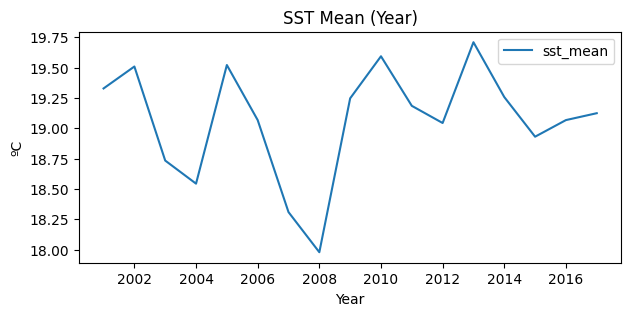

In [ ]:
sst_y.plot(
    x = 'year',
    y = 'sst_mean',
    kind = 'line',
    figsize = (7, 3),
    title='SST Mean (Year)'
)
plt.xlabel("Year")
plt.ylabel("ºC");

# Geospatial plots for SST

In [ ]:
%%bigquery geo_counts --project icoads-time-series-analysis
SELECT
    CAST(FLOOR(latitude) AS INT64) AS lat1,
    CAST(FLOOR(longitude) AS INT64) AS lon1,
    COUNT(*) AS n
FROM `icoads-time-series-analysis.icoads_data.icoads_raw_aggregated`
WHERE year BETWEEN 2005 AND 2017
GROUP BY lat1, lon1
ORDER BY lat1, lon1;

Query is running:   0%|          |

Downloading:   0%|          |

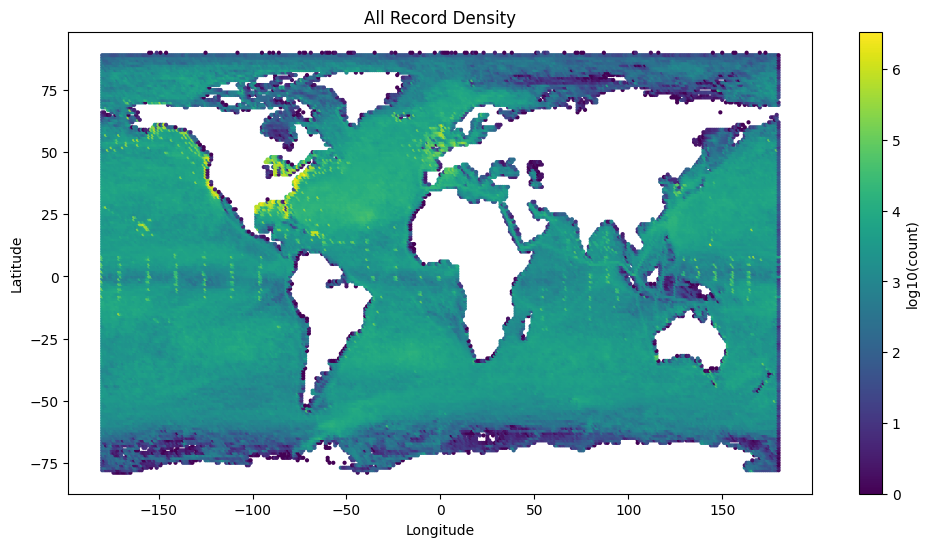

In [ ]:
df = geo_counts.copy()
df["n_log"] = np.log10(df["n"].astype(float))
fig, ax = plt.subplots(figsize = (12, 6))
sc = ax.scatter(
    df["lon1"],
    df["lat1"],
    s = 4, c = df["n_log"],
    cmap = "viridis"
)

cbar = fig.colorbar(sc, ax = ax)
cbar.set_label("log10(count)")
ax.set_title("All Record Density")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude");

## For just SST

In [ ]:
%%bigquery sst_counts --project icoads-time-series-analysis
SELECT
    CAST(FLOOR(latitude)  AS INT64) AS lat1,
    CAST(FLOOR(longitude) AS INT64) AS lon1,
    COUNT(*) AS n
FROM `icoads-time-series-analysis.icoads_data.icoads_raw_aggregated`
WHERE sea_surface_temp IS NOT NULL
    AND year BETWEEN 2005 AND 2017
GROUP BY lat1, lon1
ORDER BY lat1, lon1;

Query is running:   0%|          |

Downloading:   0%|          |

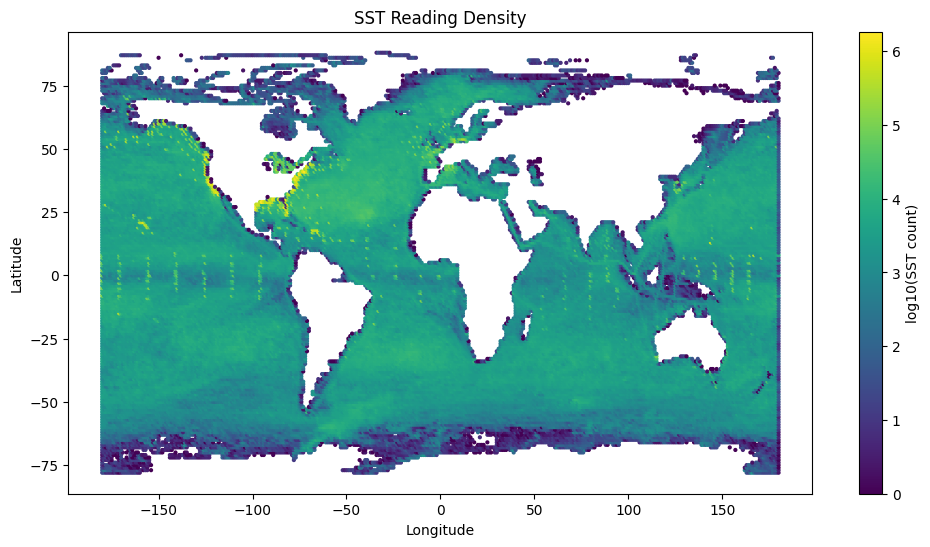

In [ ]:
df = sst_counts.copy()
df["n_log"] = np.log10(df["n"].astype(float))

fig, ax = plt.subplots(figsize = (12, 6))
sc = ax.scatter(
    df["lon1"],
    df["lat1"],
    s = 4, c = df["n_log"],
    cmap = "viridis"
)
cbar = fig.colorbar(sc, ax = ax)
cbar.set_label("log10(SST count)")
ax.set_title("SST Reading Density")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude");